1. Imports e Configurações

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import joblib
from pathlib import Path

# Reprodutibilidade
SEED = 42
np.random.seed(SEED)


2. Carregamento e Exploração Inicial dos Dados

In [8]:
BASE_DIR = Path.cwd().parents[2]
DATA_DIR = BASE_DIR / "datalake" / "data-for-model"

cassette_file = DATA_DIR / "sleep-cassette.parquet"
df_cassette = pd.read_parquet(cassette_file, engine="fastparquet")

print("Shape:", df_cassette.shape)
display(df_cassette.head())

print(df_cassette.info())
print(df_cassette["stage"].value_counts(normalize=True))  # balanceamento da variável alvo
print(df_cassette.describe())  # estatísticas descritivas

Shape: (161141, 31)


,subject_id,night_id,epoch_idx,t0_sec,stage,age,sex,tso_min,EEG_Pz_Oz_beta_relpow_256,EEG_Pz_Oz_delta_relpow_256,...,EOG_rms,EOG_beta_relpow_256,EOG_delta_relpow_256,EOG_sef95_256,EMG_submental_p90_1hz,EMG_submental_rms_1hz,EEG_Fpz_Cz_beta_relpow_256,EEG_Fpz_Cz_alpha_relpow_256,EOG_theta_relpow_256,EMG_submental_median_1hz
0,SC400,N1,991,29730.0,W,33,F,0.0,0.282421,0.434532,...,80.893494,0.099188,0.824096,21.875000,3.3808,3.337952,0.030899,0.015324,0.037745,3.329
1,SC400,N1,992,29760.0,W,33,F,0.0,0.257110,0.432998,...,92.922546,0.094244,0.811323,24.218750,3.4768,3.397615,0.023414,0.014814,0.040514,3.395
2,SC400,N1,993,29790.0,W,33,F,0.0,0.233207,0.435475,...,75.215378,0.016916,0.947214,4.296875,3.4806,3.400531,0.026188,0.015292,0.023730,3.406
3,SC400,N1,994,29820.0,W,33,F,0.0,0.220976,0.519543,...,69.292320,0.011022,0.946821,4.296875,3.4906,3.416954,0.023055,0.014219,0.030193,3.420
4,SC400,N1,995,29850.0,W,33,F,0.0,0.255602,0.443725,...,84.047935,0.006077,0.958383,3.515625,3.5248,3.434736,0.014902,0.011276,0.028883,3.425


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161141 entries, 0 to 161140
Data columns (total 31 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   subject_id                        161141 non-null  object 
 1   night_id                          161141 non-null  object 
 2   epoch_idx                         161141 non-null  int64  
 3   t0_sec                            161141 non-null  float64
 4   stage                             161141 non-null  object 
 5   age                               161141 non-null  int64  
 6   sex                               161141 non-null  object 
 7   tso_min                           161141 non-null  float64
 8   EEG_Pz_Oz_beta_relpow_256         161141 non-null  float64
 9   EEG_Pz_Oz_delta_relpow_256        161141 non-null  float64
 10  EEG_Fpz_Cz_sigma_relpow_256       161141 non-null  float64
 11  EEG_Fpz_Cz_theta_relpow_256       161141 non-null  f

3. Preparação dos Dados

In [9]:
# Define features e target
X = df_cassette.drop(columns=["stage", "subject_id", "night_id"], errors="ignore")
y = df_cassette["stage"]

# Converte colunas categóricas (se houver)
if "sex" in X.columns:
    X = pd.get_dummies(X, columns=["sex"], drop_first=True)

# Split treino/teste (20% teste, estratificado)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED, stratify=y
)

print("Treino:", X_train.shape, "Teste:", X_test.shape)


Treino: (128912, 28) Teste: (32229, 28)


4. Modelo Inicial (Baseline)

In [5]:
rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    random_state=SEED,
    n_jobs=-1,
    class_weight="balanced"
)

rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

          N1       0.64      0.39      0.48      4304
          N2       0.81      0.91      0.86     13827
          N3       0.89      0.73      0.80      2608
         REM       0.84      0.81      0.82      5167
           W       0.98      0.99      0.98     57087

    accuracy                           0.93     82993
   macro avg       0.83      0.77      0.79     82993
weighted avg       0.92      0.93      0.92     82993



5. Avaliação do Modelo

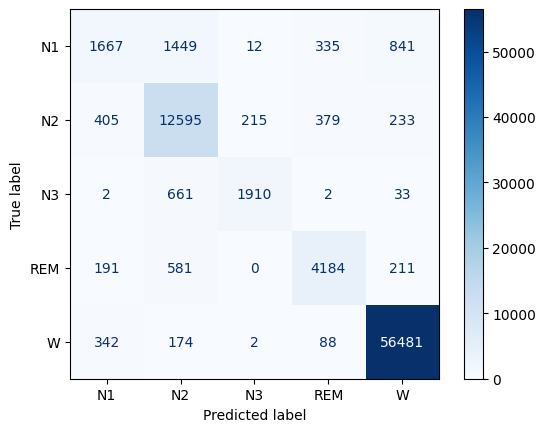

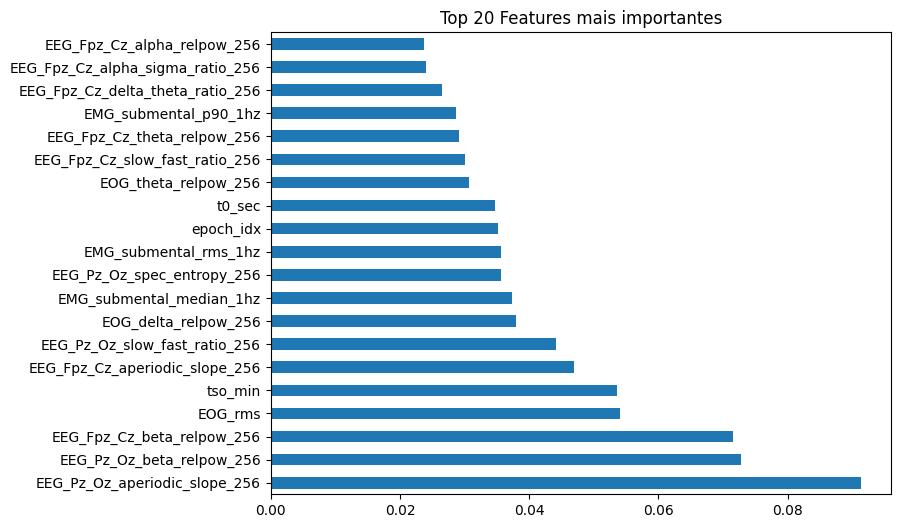

In [6]:
# Matriz de confusão
ConfusionMatrixDisplay.from_estimator(rf, X_test, y_test, cmap="Blues")
plt.show()

# Importância das features
feat_importances = pd.Series(rf.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind="barh", figsize=(8,6))
plt.title("Top 20 Features mais importantes")
plt.show()


6. Otimização de Hiperparâmetros (GridSearch)

In [ ]:
param_grid = {
    "n_estimators": [100, 300],
    "max_depth": [10, 20, None],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2],
    "max_features": ["sqrt", "log2"]
}

grid = GridSearchCV(
    RandomForestClassifier(random_state=SEED, n_jobs=-1, class_weight="balanced"),
    param_grid,
    cv=3,
    scoring="f1_macro",
    verbose=2
)

grid.fit(X_train, y_train)
best_model = grid.best_estimator_

print("Melhores parâmetros:", grid.best_params_)


#Salvando para uso futuro
output_file = "grid_search_log.txt"

with open(output_file, "w") as f:
    for i, (params, mean, std) in enumerate(zip(
        grid.cv_results_['params'],
        grid.cv_results_['mean_test_score'],
        grid.cv_results_['std_test_score']
    )):
        f.write(f"Fit {i+1}: params={params}, mean_score={mean:.4f}, std={std:.4f}\n")
    
    f.write("\nMelhores parâmetros:\n")
    for key, value in grid.best_params_.items():
        f.write(f"{key}: {value}\n")

print(f"Log completo do GridSearch salvo em '{output_file}'")


8. Modelo Final com Hiperparâmetros Otimizados

In [10]:
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    max_features="sqrt",
    min_samples_leaf=2,
    min_samples_split=5,
    random_state=SEED,
    n_jobs=-1,
    class_weight="balanced"
)

rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

          N1       0.60      0.47      0.53      4304
          N2       0.84      0.88      0.86     13827
          N3       0.85      0.78      0.81      2608
         REM       0.82      0.83      0.82      5167
           W       0.85      0.89      0.87      6323

    accuracy                           0.81     32229
   macro avg       0.79      0.77      0.78     32229
weighted avg       0.81      0.81      0.81     32229

